In [38]:
import numpy as np
from numpy import exp, array, random, dot
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import fnmatch
import os

In [21]:
data_dir = r'crops/'
classes = ['broadleaf', 'grass', 'soil', 'soybean']

#Number of images
nb_per_file = []
for c in classes:
    nb_per_file += [len(fnmatch.filter(os.listdir(data_dir+c), '*.tif'))]
nb_image_per_class = 1191 # min(nb_per_file) == 1191 (size of class with least images)
nb_files = nb_image_per_class*len(classes)

#Dimension
width = 200
height = 200 
channel = 3
input_size = width * height * channel

#Transform images into vectors
X = np.ndarray(shape=(nb_files, width, height, channel), dtype=np.float64)
Y = np.zeros(nb_files)
all_files = [] 
for i, cls in enumerate(classes):
    all_files += [f for f in glob.glob(data_dir+cls+'/*.tif')][:nb_image_per_class]
    Y[i*nb_image_per_class:(i+1)*nb_image_per_class] = i
for idx, file in enumerate(all_files):
    X[idx] = cv2.resize(cv2.imread(file), (width, height))
train_size = round(nb_files*0.90)
test_size = nb_files - train_size
X_train = np.ndarray(shape=(train_size, width, height, channel), dtype=np.float64)
X_test = np.empty(shape=(test_size, width, height, channel), dtype=np.float64)
y_train = np.zeros(train_size)
y_test = np.zeros(test_size)
y_test = np.zeros(test_size)
path_test_data = []

In [22]:
for i, cls in enumerate(classes): 
    X_test[119*i:119*(i+1)] = X[np.where(Y == i)[0][:119]]
    X_train[1072*i:1072*(i+1)] = X[np.where(Y == i)[0][119:]]
    y_test[119*i:119*(i+1)] = i
    y_train[1072*i:1072*(i+1)] = i
    path_test_data += [all_files[i] for i in list(np.where(Y == i)[0][:119])]

In [25]:
X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
#Subtracting the dataset mean serves to "center" the data
mean_image = 128
X_train -= mean_image
X_test -= mean_image

In [26]:
#2 layer neural network
import numpy as np
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))
def setParameters(X, Y, hidden_size):
    np.random.seed(3)
    input_size = X.shape[0] # number of neurons in input layer
    output_size = Y.shape[0] # number of neurons in output layer.
    W1 = np.random.randn(hidden_size, input_size)*np.sqrt(2/input_size)
    b1 = np.zeros((hidden_size, 1))
    W2 = np.random.randn(output_size, hidden_size)*np.sqrt(2/hidden_size)
    b2 = np.zeros((output_size, 1))
    return {'W1': W1, 'W2': W2, 'b1': b1, 'b2': b2}
def forwardPropagation(X, params):
    Z1 = np.dot(params['W1'], X)+params['b1']
    A1 = np.tanh(Z1)
    Z2 = np.dot(params['W2'], A1)+params['b2']
    y = sigmoid(Z2)  
    return y, {'Z1': Z1, 'Z2': Z2, 'A1': A1, 'y': y}
def cost(predict, actual):
    m = actual.shape[1]
    cost__ = -np.sum(np.multiply(np.log(predict), actual) + np.multiply((1 - actual), np.log(1 - predict)))/m
    return np.squeeze(cost__)
def backPropagation(X, Y, params, cache):
    m = X.shape[1]
    dy = cache['y'] - Y
    dW2 = (1 / m) * np.dot(dy, np.transpose(cache['A1']))
    db2 = (1 / m) * np.sum(dy, axis=1, keepdims=True)
    dZ1 = np.dot(np.transpose(params['W2']), dy) * (1-np.power(cache['A1'], 2))
    dW1 = (1 / m) * np.dot(dZ1, np.transpose(X))
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
def updateParameters(gradients, params, learning_rate = 1.2):
    W1 = params['W1'] - learning_rate * gradients['dW1']
    b1 = params['b1'] - learning_rate * gradients['db1']
    W2 = params['W2'] - learning_rate * gradients['dW2']
    b2 = params['b2'] - learning_rate * gradients['db2']
    return {'W1': W1, 'W2': W2, 'b1': b1, 'b2': b2}

def fit(X, Y, learning_rate, hidden_size, number_of_iterations = 5000):
    params = setParameters(X, Y, hidden_size)
    cost_ = []
    for j in range(number_of_iterations):
        if j % 10 == 0:
            print(j)
        y, cache = forwardPropagation(X, params)
        costit = cost(y, Y)
        gradients = backPropagation(X, Y, params, cache)
        params = updateParameters(gradients, params, learning_rate)
        cost_.append(costit)
    return params, cost_

In [27]:
#Multiclass classification
param_classes = []
cache_classes = []
for i, cls in enumerate(classes):
    nn_y_train = np.array(y_train)
    nn_y_train[nn_y_train == i ] = -1
    nn_y_train[nn_y_train >= 0 ] = 0
    nn_y_train[nn_y_train == -1 ] = 1
    nn_X_train = np.array(X_train)
    print("Binarized i: "+str(i)+", class: "+cls)
    print(y_train)
    print(nn_y_train)
    #Take same distribution positive/negative class
    y_train_idx_pos = np.where(y_train == i)[0]
    y_train_idx_neg = np.where(y_train != i)[0][:y_train_idx_pos.shape[0]]
    y_train_idx = np.concatenate((y_train_idx_pos, y_train_idx_neg), axis=0)
    index_shuffle = np.random.permutation(y_train_idx)
    nn_y_train = nn_y_train[index_shuffle]
    nn_X_train = nn_X_train[index_shuffle]
    X, Y = nn_X_train.T, nn_y_train.reshape(1, nn_y_train.shape[0])
    params, cost_ = fit(X, Y, 1e-3, 200, 100)
    import matplotlib.pyplot as plt
    plt.plot(cost_)
    param_classes += [params]
    cache_classes += [cost_]

Binarized i: 0, class: broadleaf
[0. 0. 0. ... 3. 3. 3.]
[1. 1. 1. ... 0. 0. 0.]
0
10
20
30
40
50
60
70
80
90
Binarized i: 1, class: grass
[0. 0. 0. ... 3. 3. 3.]
[0. 0. 0. ... 0. 0. 0.]
0
10
20
30
40
50
60
70
80
90
Binarized i: 2, class: soil
[0. 0. 0. ... 3. 3. 3.]
[0. 0. 0. ... 0. 0. 0.]
0
10
20
30
40
50
60
70
80
90
Binarized i: 3, class: soybean
[0. 0. 0. ... 3. 3. 3.]
[0. 0. 0. ... 1. 1. 1.]
0
10
20
30
40
50
60
70
80
90


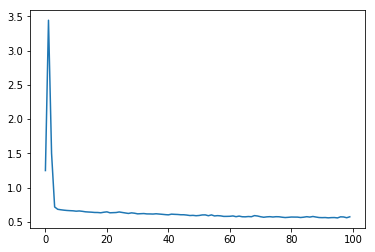

In [41]:
plt.plot(cache_classes[0])

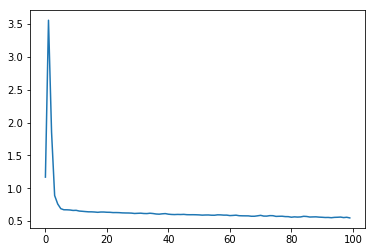

In [42]:
plt.plot(cache_classes[1])

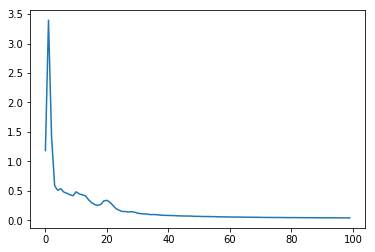

In [43]:
plt.plot(cache_classes[2])

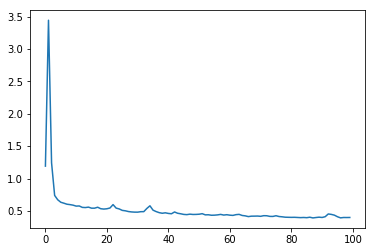

In [44]:
plt.plot(cache_classes[3])

In [82]:
def predict(param_classes, indice_test):
    file = path_test_data[indice_test]
    
    results = []
    max_value = 0
    max_class = ""
    for i, cls in enumerate(classes):
        nn_y_test = np.array(y_test)
        nn_y_test[nn_y_test == i ] = -1
        nn_y_test[nn_y_test >= 0 ] = 0
        nn_y_test[nn_y_test == -1 ] = 1
        nn_X_test = np.array(X_test)
        X, Y = nn_X_test.T, nn_y_test.reshape(1, nn_y_test.shape[0])
        y, cache = forwardPropagation(X[:, indice_test:indice_test+1], param_classes[i])
        y = y[0][0]
        if y > max_value:
            max_class = cls
            max_value = y
        results += [y]
    
    print("File name: "+file)
    img = cv2.imread(file)
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    actual = file.split('\\')[0].replace('crops/', '')
    plt.title("Actual: "+actual+", Predicted:"+max_class)
    plt.show()

File name: crops/broadleaf\1016.tif


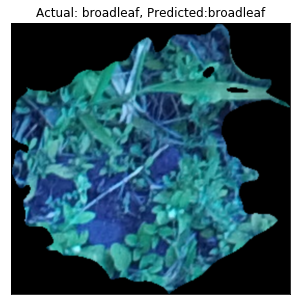

In [83]:
predict(param_classes , 20)

File name: crops/grass\1071.tif


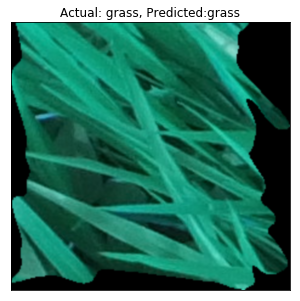

In [84]:
predict(param_classes , 200)